In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import copy

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_set = pd.read_csv('../input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

In [3]:
# ワンホットエンコーディング
data = pd.get_dummies(data_set.loc[:, 'Type':'Tool wear [min]'], dtype='float64')

# スケール化
data.loc[:, 'Air temperature [K]':'Tool wear [min]'] = MinMaxScaler().fit_transform(data.loc[:, 'Air temperature [K]':'Tool wear [min]'])

data['Target'] = data_set['Target']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  float64
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  float64
 5   Type_H                   10000 non-null  float64
 6   Type_L                   10000 non-null  float64
 7   Type_M                   10000 non-null  float64
 8   Target                   10000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 703.2 KB


In [4]:
train, test = train_test_split(data, train_size=0.7, random_state=42)
print('0: {}'.format((train.Target == 0).sum()))
print('1: {}'.format((train.Target == 1).sum()))

0: 6754
1: 246


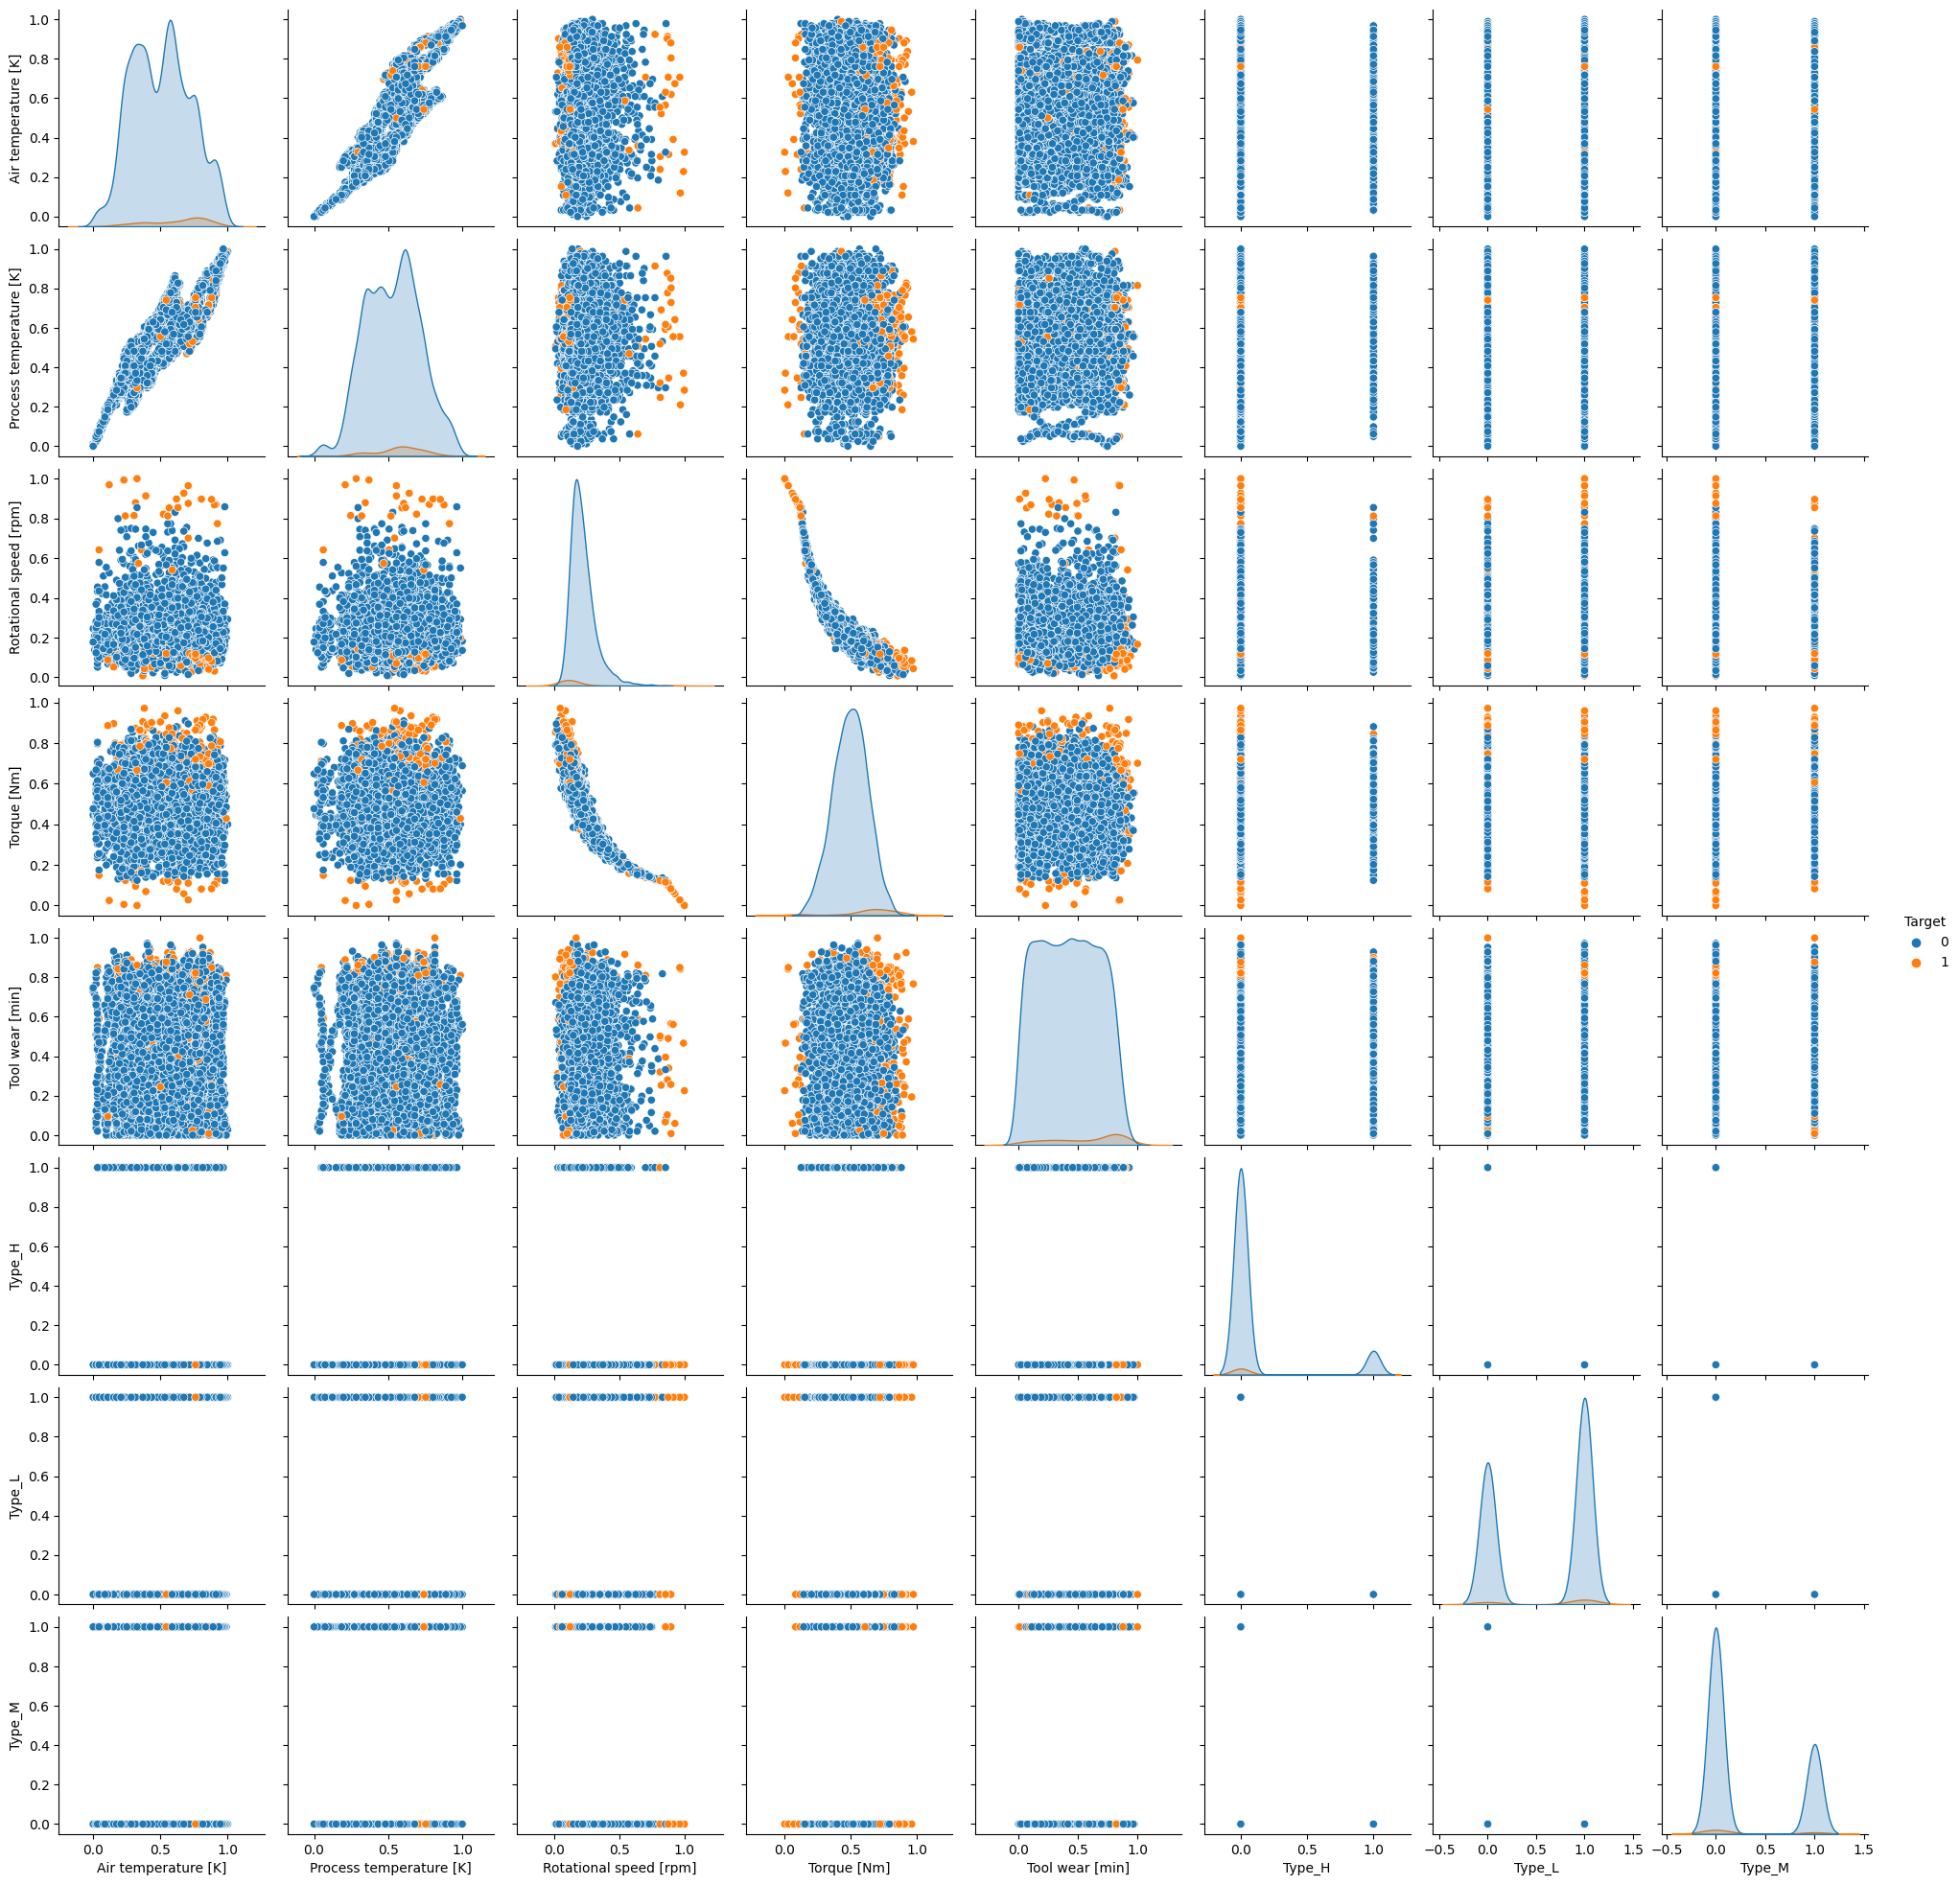

In [56]:
# ペアプロット
sns.pairplot(train, vars=train.columns[:-1], hue=train.columns[-1])

# SMOTE (パラメータによる違い)

In [50]:
X_test = test.drop(columns='Target', axis=1)
y_test = test['Target']

# パイプライン
pipe = Pipeline([('classify', RandomForestClassifier(random_state=10, max_features='sqrt', class_weight='balanced'))])
param_test = {'classify__n_estimators': list(range(11, 13, 1)),
              'classify__max_depth': list(range(6, 9, 1))}

# グリッドサーチ
grid = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='recall', cv=10)

In [33]:
# データ拡張数による違い

ratio_list = np.round(np.linspace(0.1, 1, 10), 1)
recall_score_arr = np.empty(0)

for ratio in ratio_list:
    sm = SMOTE(k_neighbors=5, random_state=42, sampling_strategy=ratio)
    X = train.drop(columns='Target', axis=1)
    y = train['Target']
    X_train, y_train = sm.fit_resample(X, y)
    
    grid.fit(X_train, y_train)
    predict = grid.predict(X_test)
    print('{}:'.format(ratio))
    print('best_params_: {}\nbest_score_: {:.3f}'.format(grid.best_params_, grid.best_score_))
    recall_score_arr = np.append(recall_score_arr, recall_score(y_test, predict))
    print('test_score_: {:.3f}'.format(recall_score(y_test, predict)))
    print()

0.1:
best_params_: {'classify__max_depth': 7, 'classify__n_estimators': 13}
best_score_: 0.901
test_score_: 0.688

0.2:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.927
test_score_: 0.731

0.3:
best_params_: {'classify__max_depth': 7, 'classify__n_estimators': 12}
best_score_: 0.946
test_score_: 0.710

0.4:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.949
test_score_: 0.710

0.5:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.957
test_score_: 0.742

0.6:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.957
test_score_: 0.763

0.7:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.961
test_score_: 0.774

0.8:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.965
test_score_: 0.785

0.9:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best

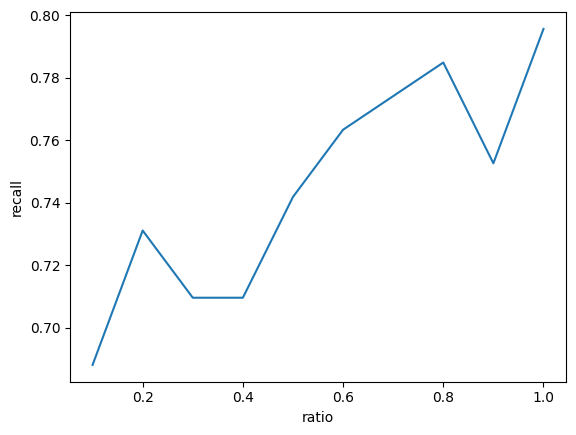

In [35]:
plt.xlabel('ratio')
plt.ylabel('recall')
plt.plot(ratio_list, recall_score_arr)

In [43]:
# k近傍数による違い

k_neighbors_list = np.arange(1, 16)
recall_score_arr = np.empty(0)

for k_neighbors in k_neighbors_list:
    sm = SMOTE(k_neighbors=k_neighbors, random_state=42)
    X = train.drop(columns='Target', axis=1)
    y = train['Target']
    X_train, y_train = sm.fit_resample(X, y)
    
    grid.fit(X_train, y_train)
    predict = grid.predict(X_test)
    print('{}:'.format(k_neighbors))
    print('best_params_: {}\nbest_score_: {:.3f}'.format(grid.best_params_, grid.best_score_))
    recall_score_arr = np.append(recall_score_arr, recall_score(y_test, predict))
    print('test_score_: {:.3f}'.format(recall_score(y_test, predict)))
    print()

1:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.983
test_score_: 0.763

2:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.975
test_score_: 0.731

3:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.967
test_score_: 0.699

4:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.968
test_score_: 0.742

5:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.963
test_score_: 0.796

6:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.960
test_score_: 0.774

7:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.960
test_score_: 0.763

8:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.959
test_score_: 0.828

9:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.955
tes

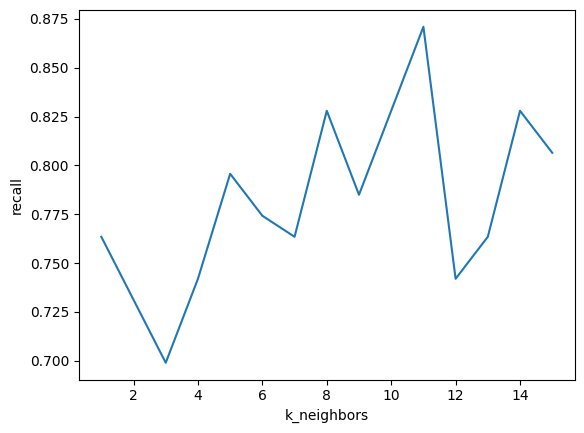

In [44]:
plt.xlabel('k_neighbors')
plt.ylabel('recall')
plt.plot(k_neighbors_list, recall_score_arr)

In [51]:
# データ拡張数による違い (k_neighbors=11)

ratio_list = np.round(np.linspace(0.1, 1, 10), 1)
recall_score_arr = np.empty(0)

for ratio in ratio_list:
    sm = SMOTE(k_neighbors=11, random_state=42, sampling_strategy=ratio)
    X = train.drop(columns='Target', axis=1)
    y = train['Target']
    X_train, y_train = sm.fit_resample(X, y)
    
    grid.fit(X_train, y_train)
    predict = grid.predict(X_test)
    print('{}:'.format(ratio))
    print('best_params_: {}\nbest_score_: {:.3f}'.format(grid.best_params_, grid.best_score_))
    recall_score_arr = np.append(recall_score_arr, recall_score(y_test, predict))
    print('test_score_: {:.3f}'.format(recall_score(y_test, predict)))
    print()

0.1:
best_params_: {'classify__max_depth': 6, 'classify__n_estimators': 12}
best_score_: 0.865
test_score_: 0.753

0.2:
best_params_: {'classify__max_depth': 7, 'classify__n_estimators': 11}
best_score_: 0.912
test_score_: 0.720

0.3:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 11}
best_score_: 0.927
test_score_: 0.688

0.4:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 11}
best_score_: 0.931
test_score_: 0.731

0.5:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 11}
best_score_: 0.941
test_score_: 0.785

0.6:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 11}
best_score_: 0.939
test_score_: 0.849

0.7:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.940
test_score_: 0.785

0.8:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best_score_: 0.946
test_score_: 0.796

0.9:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 12}
best

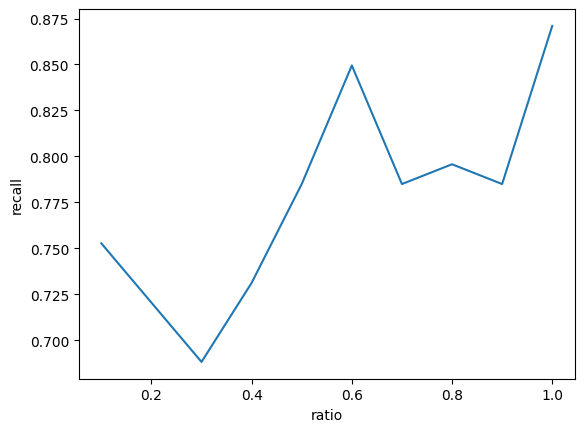

In [52]:
plt.xlabel('ratio')
plt.ylabel('recall')
plt.plot(ratio_list, recall_score_arr)

# 考察

In [ ]:
"""
・SMOTEは2002年に考案された手法で, 現在までにSMOTEを用いた多くの拡張手法が提案されている (周辺の多数派データとの兼ね合いやgap値の計算方法など)
・ratioに依らず, 過学習が強く発生している ⇔ データ拡張なしのランダムフォレスト(重み付け)では訓練0.85, テスト0.81であり, 拡張がどんなデータに対しても有効とはいえない
・ratioに対する再現率は上昇傾向
・k_naighborsに関して, 新しくデータを生成する対象となるk近傍点はランダムであるため, 再現率は確率に大きく依存すると考えられ, 全体的な傾向は見受けられず, 不規則に変化
"""